# Exploratory Data Analysis

In [11]:
cd C:\Users\Majd Mustapha\DSP\AirlineSentimentAnalysis\

C:\Users\Majd Mustapha\DSP\AirlineSentimentAnalysis


In [12]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import general_utilities as gu
from wordcloud import WordCloud

from IPython.display import display
from sys import getsizeof
import matplotlib.pyplot as plt
from IPython.display import Image

# storing data directories for this notebook.
img_out_dir = 'data/images/Tech_Pres/'
data_out_dir = 'data/pickled/Tech_Pres/'

# used to print word cloud in twitter bird shape.
from PIL import Image
wc_image_mask = np.array(Image.open('data/twitter.png'))

img_EDA_NB1 = "data/images/EDA_NB1_emoji_encoding/"

%matplotlib inline

1. #### Exploration and Analysis of the data</b>:
  1. Standardized case (to lower)
  2. Removed puntuations
  3. Removed stop words
  4. Normalized data using stemming/lemmatization.
    1. Lemmatization: look for base of the word.<br>
       am, are, is $\Rightarrow$ be<br> 
       car, cars, car's, cars' $\Rightarrow$ car
    2. Stemming: chops off the end of words based on certain alogithms.<br>
        The most common seems to be Porter's algorithm.<br>
        sses, ies, ss, s $\Rightarrow$ ss, i, s, ''<br>
        caresses, ponies, caress, cats $\Rightarrow$ caress, poni, caress, cat
  5. Encoded emojis separately as individual features.
    1. Extracted emojis from input text.
    2. Declumped emojis, since users group them together.<br>
    3. Created a dictionary of emojis and codes for all the emojis found in the dataset.<br>
  6. Looked at effects of dimensionality reduction by separately
     <br>analyzing 'clean_text', 'adding stopwords', 'adding stemming', 'lemmatizing'.
  7. Explored characteristics of different n-gram features, using CounVectorizer.<br>
     Looked at the classifier words:
    1. What are the top words for each category, with the different processed texts? 
      1. Made a wordcloud for each category.
      2. Made bar charts of top 50 words for each category.<br>

### `For more details about my work on this topic refer to:`
[Data Batch1 with no emoji encoding: EDA](../ipynb/EDA/EDA_DataBatch1_noEmojiEnc_NB1.ipynb) <br>
[Data Batch2 with no emoji encoding: EDA](../ipynb/EDA/EDA_DataBatch2_noEmojiEnc_NB2.ipynb) <br>
[Data Batch1 with emoji encoding:    EDA](../ipynb/EDA/EDA_DataBatch1_withEmojiEnc_NB3.ipynb) <br>
[Data Batch2 with emoji encoding:    EDA](../ipynb/EDA/EDA_DataBatch2_withEmojiEnc_NB4.ipynb) <br>

In [13]:
# Load original Kaggle dataset.
filename = "data/csvfiles/kaggle_airline_dataset.csv"
orig_data_df = pd.read_csv(filename, encoding='utf-8')
orig_data_df.head(1)

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                           1.0   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   

  airline_sentiment_gold     name negativereason_gold  retweet_count  \
0                    NaN  cairdin                 NaN              0   

                                  text tweet_coord              tweet_created  \
0  @VirginAmerica What @dhepburn said.         NaN  2015-02-24 11:35:52 -0800   

  tweet_location               user_timezone  
0            NaN  Eastern Time (US & Canada)

### Dataset has 14640 tweets. However as seen below, some have lower classification confidence levels. I will use the ones with conf level >= .7

In [14]:
orig_data_df.shape

(14640, 15)

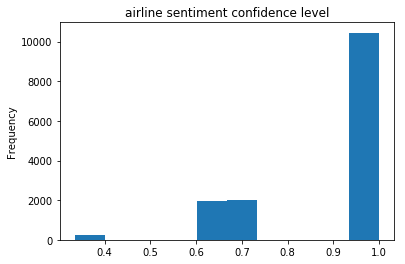

In [15]:
# look at the confidence values for the 3 categories.
orig_data_df.airline_sentiment_confidence.plot(kind='hist', title='airline sentiment confidence level')

In [16]:
# I chose to only look at data with classification confidence levels >= 70%
mask = orig_data_df.airline_sentiment_confidence >= 0.7
subset_df = orig_data_df.loc[mask,:]
subset_df.shape

(10768, 15)

### The data is highly imbalanced towards the negative class.
Looks like people most use social media to complain about airlines! 

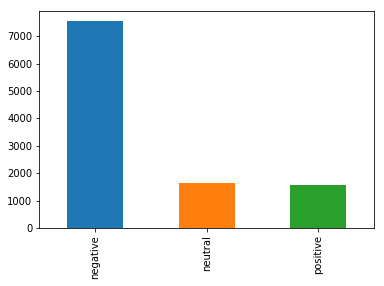

In [17]:
# look at the count of values for the 3 categories.
subset_df.airline_sentiment.value_counts().plot(kind='bar')

### How are the major airlines doing with regards to customer satisfaction?
Well, from the plot below, we can see that in 2015, United, US Airways and American airlines<br>
had relatively much higher negative feedback than say Virgin America, Southwest and Delta.

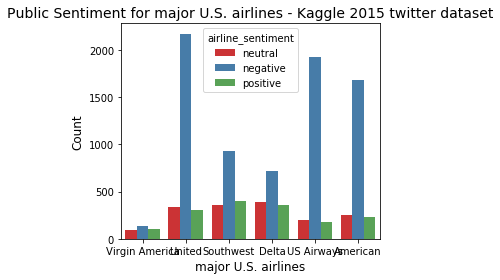

In [18]:
# Airline sentiment.
sns.countplot(x="airline", hue="airline_sentiment", data=subset_df, palette = 'Set1')
plt.title('Public Sentiment for major U.S. airlines - Kaggle 2015 twitter dataset',
         fontsize=14)
plt.xlabel('major U.S. airlines', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()

In [ ]:
# Countplot plots the counts of values.
# I want to display the percentage of negatie, neutral and positive tweets, for each airline.

In [19]:
# Create mask to group airlines by sentiment, to find value counts.
mask_neg = subset_df['airline'][subset_df.airline_sentiment=='negative']
mask_neut = subset_df['airline'][subset_df.airline_sentiment=='neutral']
mask_pos = subset_df['airline'][subset_df.airline_sentiment=='positive']

airline_tweet_totals = subset_df.airline.value_counts()
neg = mask_neg.value_counts(); neut = mask_neut.value_counts(); pos = mask_pos.value_counts()

# Now sort the index so all sentiment series have same airline order.
neg.sort_index(inplace=True); pos.sort_index(inplace=True); 
neut.sort_index(inplace=True); airline_tweet_totals.sort_index(inplace=True);

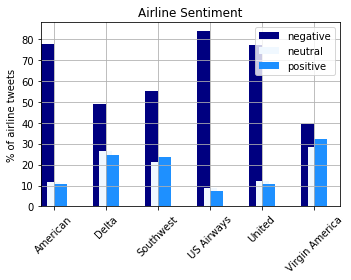

In [20]:
# Display y-axis as percentage. 
perc_neg = (neg/airline_tweet_totals)*100
perc_pos = (pos/airline_tweet_totals)*100
perc_neut = (neut/airline_tweet_totals)*100

width=0.25
plt.figure(figsize=(5,4))
perc_neg.plot(kind='bar', color='navy', width=width, position=1, title='Airline Sentiment')
perc_neut.plot(kind='bar', color='aliceblue', width= width, position=0.5, title='Airline Sentiment')
perc_pos.plot(kind='bar', color='dodgerblue', width=width, position=0, title='Airline Sentiment')
plt.legend(('negative', 'neutral', 'positive'))
plt.grid(True)
plt.xticks(rotation=45)
plt.ylabel('% of airline tweets')
plt.tight_layout()

### What are the major topics with regards to customer disatisfaction?
Well, from the plot below, we can see that in 2015, customers were most dissatisfied with<br>
`customer service issues`, `late flights`, `cancelled flights` and `lost luggage`.

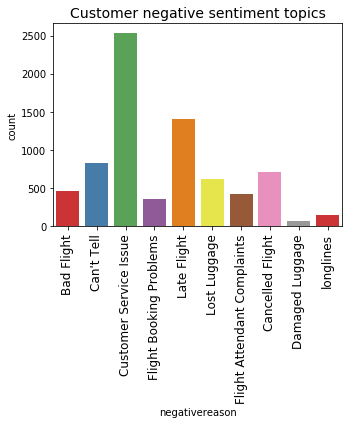

In [21]:
plt.figure(figsize=(5,6))
sns.countplot(x="negativereason", data=subset_df, palette = "Set1")
plt.grid(0)
plt.xticks(rotation = 90, fontsize=12)
plt.title("Customer negative sentiment topics", fontsize=14)
plt.tight_layout()

### This airline sentiment clasification and customer disatisfaction topics, were labelled by humans.<br>
### My Goal:
To see if machine learning techiques can achieve these two tasks, and if so how well:<br>
1. Sentiment classification.
2. Topic inference from unknown text, through unsupervised learning models, such as LDA.

### Clean text, reducing noise by using stopwords and normalize data with Stemming/lemma
1. Standardized case (to lower)
2. Removed puntuations
3. Removed stop words
4. Normalized data using stemming/lemmatization.
  1. Lemmatization: look for base of the word.<br>
     am, are, is $\Rightarrow$ be<br> 
     car, cars, car's, cars' $\Rightarrow$ car
  2. Stemming: chops off the end of words based on certain alogithms.<br>
      The most common seems to be Porter's algorithm.<br>
      sses, ies, ss, s $\Rightarrow$ ss, i, s, ''<br>
      caresses, ponies, caress, cats $\Rightarrow$ caress, poni, caress, cat

### I created 2 sets of data, one `with emoji encoding` and one `without emoji encoding`.<br>I want to see if including emojis as predictors, improves the model performance.

In [25]:
# Load processed pickled dataset with emoji encoding..
filename = 'data/processed_dataset_df/airline_proc_dataset_70percCL_withEmEnc_df'
proc_df = gu.read_pickle_obj(filename)

text_cols = ['text', 'clean_text', 'stopw_clean_text', 'stem_stopw_clean_text', 'lemma_stopw_clean_text']
proc_df[text_cols][8:11]

IOError: [Errno 2] No such file or directory: 'data/processed_dataset_df/airline_proc_dataset_70percCL_withEmEnc_df'

In [90]:
# raw text
print('Raw Text:\n', proc_df['text'][1])

# cleaned text (removed urls, @users, punctuations...)
print('\nClean Text:\n', proc_df['clean_text'][1])

# added elimination of stopwords 
print('\nUsing stopwords:\n', proc_df['stopw_clean_text'][1])

# added stemming
print('\nUsing stemming:\n', proc_df['stem_stopw_clean_text'][1])

# added lemmatization
print('\nUsing lemmatization:\n', proc_df['lemma_stopw_clean_text'][1])

Raw Text:
 @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse

Clean Text:
 its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse

Using stopwords:
 really aggressive blast obnoxious entertainment guests faces little recourse

Using stemming:
 realli aggress blast obnoxi entertain guest face littl recours

Using lemmatization:
 really aggressive blast obnoxious entertainment guest face amp little recourse


In [7]:
# Load processed pickled no emoji enc dataset.
filename = 'data/processed_dataset_df/airline_proc_dataset_70percCL_noEmEnc_addLemma_df'
df = gu.read_pickle_obj(filename)

text_cols = ['text', 'clean_text', 'stopw_clean_text', 'stem_stopw_clean_text']
df[text_cols][8:11]

text  \
8   @VirginAmerica So excited for my first cross c...   
9   @VirginAmerica  I flew from NYC to SFO last we...   
10                    I ❤️ flying @VirginAmerica. ☺️👍   

                                           clean_text  \
8   so excited for my first cross country flight l...   
9   i flew from nyc to sfo last week and couldnt f...   
10                                    i ❤️ flying ☺️👍   

                                     stopw_clean_text  \
8   excited cross country lax mco ive heard great ...   
9   flew nyc sfo week fully sit seat large gentlem...   
10                                      ❤️ flying ☺️👍   

                                stem_stopw_clean_text  
8   excit cross countri lax mco ive heard great th...  
9   flew nyc sfo week fulli sit seat larg gentlema...  
10                                         ❤️ fli ☺️👍

In [89]:
# NOTICE: No emojis are encoded.
del df

```I encoded emojis separately, so they could be added as features by the text vectorizers.```<br>
```Users tend to clump emojis in text together. For now I was interested in exploring them```<br>
```as individual features.```

5. Encoded emojis separately as individual features.
    1. Extracted emojis from input text.
    2. Declumped emojis, since users group them together.<br>
    `NOTE`: `Can continue to further explore using group of emojis as features`.
    3. Created a dictionary of emojis and codes for all the emojis found in the dataset.<br>
    `NOTE`: `Can continue to further explore expanding the emoji features supported`.<br><br>

`For more details about my work on this topic refer to:`<br>
[Emoji Notebook](EmojiExploration/EmojiExplore_FullDataset_NB2.ipynb) 

In [88]:
# Extract emojis in the text, to get a feel for which ones tend to be used for each sentiment class.
proc_df[['emojis', 'airline_sentiment']][proc_df.emojis!=''][:20].T

10        15        19        24       27        73   \
emojis                ❤ ☺ 👍         😡         😢       💜 ✈  🍷 👍 💺 ✈       💕 💕   
airline_sentiment  positive  negative  negative  positive  neutral  positive   

                        138       146       164       165       176       180  \
emojis                    😁         ❤         👏       😂 💗         🍸         😒   
airline_sentiment  negative  positive  positive  positive  positive  negative   

                        191        194      198       220      224       234  \
emojis                    👎  👍 👍 ✈ ✈ 💗  😊 😀 😃 😄         😎      👸 💗         😥   
airline_sentiment  negative    neutral  neutral  positive  neutral  negative   

                       235       298  
emojis               🎀 🎀 🎀       ✈ 🎉  
airline_sentiment  neutral  positive

In [79]:
# From these extracted emojis I created an emoji dictionary to encode them, so the
# vectorizers would interpret them as features.

# read in pickled emoji dictionary I created from emojis in the dataset. I want to use
# each emoji as an individual feature.
file = 'data/pickled/Emoticon_NB4/full_emoji_dict.obj'
emoji_dict = gu.read_pickle_obj(file)
print(emoji_dict)

{'❤': 'EMOJI_1', '☺': 'EMOJI_2', '👍': 'EMOJI_3', '😡': 'EMOJI_4', '😢': 'EMOJI_5', '💜': 'EMOJI_6', '✈': 'EMOJI_7', '🍷': 'EMOJI_8', '💺': 'EMOJI_9', '😊': 'EMOJI_10', '😍': 'EMOJI_11', '👌': 'EMOJI_12', '💕': 'EMOJI_13', '🌞': 'EMOJI_14', '😃': 'EMOJI_15', '😩': 'EMOJI_16', '😭': 'EMOJI_17', '😎': 'EMOJI_18', '🙉': 'EMOJI_19', '😁': 'EMOJI_20', '❄': 'EMOJI_21', '👏': 'EMOJI_22', '😂': 'EMOJI_23', '💗': 'EMOJI_24', '🍸': 'EMOJI_25', '😒': 'EMOJI_26', '👎': 'EMOJI_27', '😀': 'EMOJI_28', '😄': 'EMOJI_29', '😘': 'EMOJI_30', '👸': 'EMOJI_31', '🎀': 'EMOJI_32', '🌏': 'EMOJI_33', '😥': 'EMOJI_34', '😉': 'EMOJI_35', '✨': 'EMOJI_36', '😱': 'EMOJI_37', '🎉': 'EMOJI_38', '🙌': 'EMOJI_39', '💤': 'EMOJI_40', '😞': 'EMOJI_41', '♥': 'EMOJI_42', '👋': 'EMOJI_43', '✌': 'EMOJI_44', '🙏': 'EMOJI_45', '👿': 'EMOJI_46', '😔': 'EMOJI_47', '🙅': 'EMOJI_48', '🆖': 'EMOJI_49', '💩': 'EMOJI_50', '✔': 'EMOJI_51', '🌴': 'EMOJI_52', '✅': 'EMOJI_53', '❌': 'EMOJI_54', '👠': 'EMOJI_55', '😜': 'EMOJI_56', '😻': 'EMOJI_57', '😕': 'EMOJI_58', '😈': 'EMOJI_59', '😤': 

In [114]:
print(proc_df[['text', 'clean_text']][proc_df.emojis!=''].values[:5])

[['I ❤️ flying @VirginAmerica. ☺️👍' 'i  EMOJI_1️ flying  EMOJI_2️ EMOJI_3']
 [ '@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet'
  'you guys messed up my seating i reserved seating with my friends and you guys gave my seat away   EMOJI_4 i want free internet']
 [ "@VirginAmerica hi! I just bked a cool birthday trip with you, but i can't add my elevate no. cause i entered my middle name during Flight Booking Problems 😢"
  'hi i just bked a cool birthday trip with you but i cant add my elevate no cause i entered my middle name during flight booking problems  EMOJI_5']
 [ '@VirginAmerica Moodlighting is the only way to fly! Best experience EVER! Cool and calming. 💜✈ #MoodlitMonday'
  'moodlighting is the only way to fly best experience ever cool and calming  EMOJI_6 EMOJI_7 moodlitmonday']
 [ '@VirginAmerica plz help me win my bid upgrade for my flight 2/27 LAX---&gt;SEA!!!  🍷👍💺✈️'
  'plz help me w

In [11]:
import emoji
def declump_emojis_in_text(text):
    em_txt = text        
    for i in text:
        if (i in emoji.UNICODE_EMOJI):
            em_txt = em_txt.replace(i,' '+i)
        
    return(em_txt)

In [13]:
tweet = proc_df.loc[27, 'text']
print(tweet, '\n')
print(declump_emojis_in_text(tweet))

@VirginAmerica plz help me win my bid upgrade for my flight 2/27 LAX---&gt;SEA!!!  🍷👍💺✈️ 

@VirginAmerica plz help me win my bid upgrade for my flight 2/27 LAX---&gt;SEA!!!   🍷 👍 💺 ✈️



### Explore N-Grams.<br>What do they say?<br>What effects do different dimensionality reduction methods have on model predictions?

5. Looked at effects of dimensionality reduction by separately
   <br>analyzing 'clean_text', 'adding stopwords', 'adding stemming', 'lemmatizing'.
6. Explored characteristics of different n-gram features, using CounVectorizer.<br>
   Looked at the classifier words:
  1. What are the top words for each category, with the different processed texts? 
    2. Made bar charts of top 50 words for each category.<br>
   `NOTE`: Can further explore this by using TfidfVectorizer to see the differences.

#### NOTE: `For further reference to my EDA work, refer to the EDA notebooks, in the links above`.<br>

In [ ]:
from IPython.display import Image
from IPython.display import display

### Now lets take a look at different n-gram features, for the different processed text and compare.

### Top Uni-grams - Data type: cleaned text (urls, @users, punctuations...) + stopwords
NOTE: I examined grams for all data types: `clean text only`, `stopwords added` and `stemming added`.<br>
Out of all 3 data types, `clean text + stopwords` seemed to be the most informative one. So this is the data type I will present below.

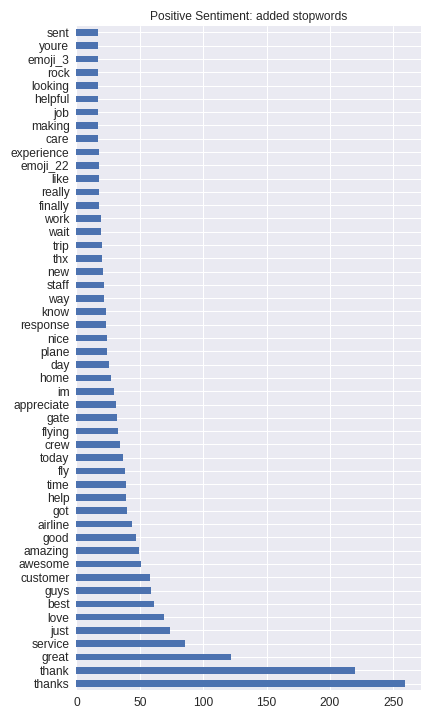

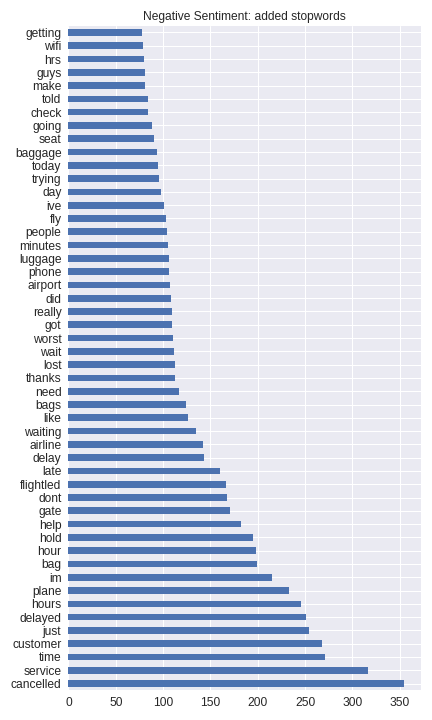

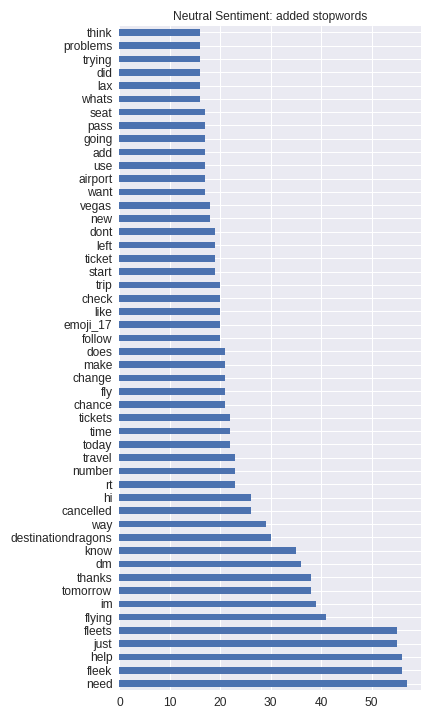

In [78]:
im = Image(filename = img_EDA_NB1 + "Unigrams_pos_sent_stopwused.png")
display(im)

im = Image(filename = img_EDA_NB1 + "Unigrams_neg_sent_stopwused.png")
display(im)

im = Image(filename = img_EDA_NB1 + "Unigrams_neut_sent_stoopwused.png")
display(im)

### Uni-grams observed for the 3 classes using  cleaned text + stopwords

In [ ]:
# Positive Unigrams:
#        ['thanks', 'thank', 'great', 'service', 'just', 'love', 'best', 'guys',
#        'customer', 'awesome', 'amazing', 'good', 'airline', 'got', 'help',
#        'time', 'fly', 'today', 'crew', 'flying', 'gate', 'appreciate', 'im',
#        'home', 'day', 'plane', 'nice', 'response', 'know', 'way', 'staff',
#        'new', 'thx', 'trip', 'wait', 'work', 'finally', 'really', 'like',
#        'emoji_22', 'experience', 'care', 'making', 'job', 'helpful', 'looking',
#        'rock', 'emoji_3', 'youre', 'sent']

# Negative Unigrams:
#        ['cancelled', 'service', 'time', 'customer', 'just', 'delayed', 'hours',
#        'plane', 'im', 'bag', 'hour', 'hold', 'help', 'gate', 'dont',
#        'flightled', 'late', 'delay', 'airline', 'waiting', 'like', 'bags',
#        'need', 'thanks', 'lost', 'wait', 'worst', 'got', 'really', 'did',
#        'airport', 'phone', 'luggage', 'minutes', 'people', 'fly', 'ive', 'day',
#        'trying', 'today', 'baggage', 'seat', 'going', 'check', 'told', 'make',
#        'guys', 'hrs', 'wifi', 'getting']

# Neutral Unigrams:
#        ['need', 'fleek', 'help', 'just', 'fleets', 'flying', 'im', 'tomorrow',
#        'thanks', 'dm', 'know', 'destinationdragons', 'way', 'cancelled', 'hi',
#        'rt', 'number', 'travel', 'today', 'time', 'tickets', 'chance', 'fly',
#        'change', 'make', 'does', 'follow', 'emoji_17', 'like', 'check', 'trip',
#        'start', 'ticket', 'left', 'dont', 'new', 'vegas', 'want', 'airport',
#        'use', 'add', 'going', 'pass', 'seat', 'whats', 'lax', 'did', 'trying',
#        'problems', 'think']

### Observations: 
There are a `few overlapping words between classes`, but they `differ in ranking`.<br>
This is definitely needed to effectively be able to do  classification.<br>
Also I notice that the `emoji shows up as a top features for the positive and neutral class`.

### Top Bigrams  for the 3 classes using  cleaned text + stopwords

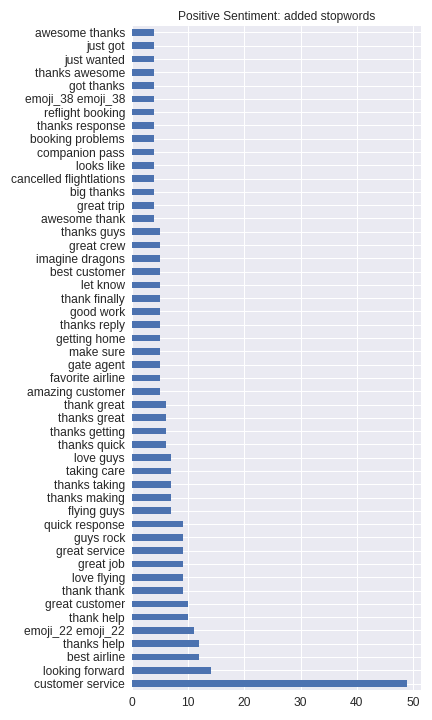

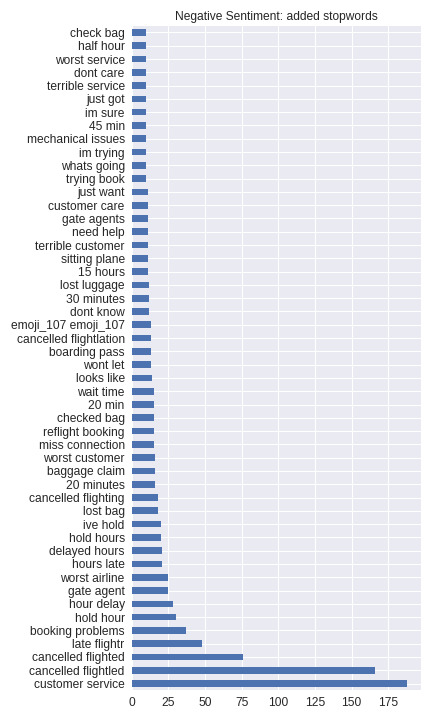

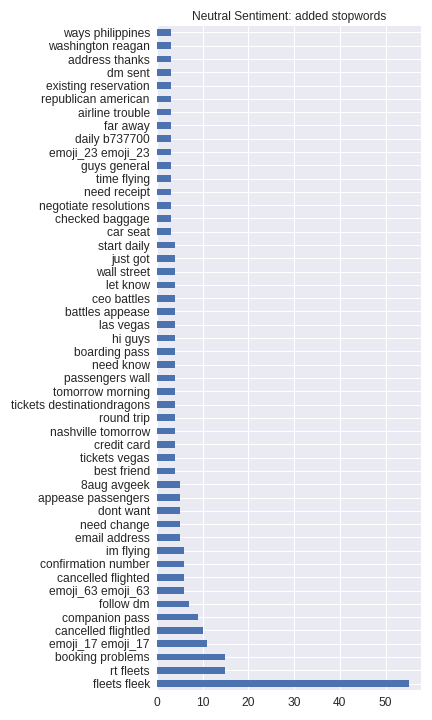

In [75]:
im = Image(filename = img_EDA_NB1 + "Bigrams_pos_sent_stopwused.png")
display(im)

im = Image(filename = img_EDA_NB1 + "Bigrams_neg_sent_stopwused.png")
display(im)

im = Image(filename = img_EDA_NB1 + "Bigrams_neut_sent_stopwused.png")
display(im)

### Bi-grams observed for the 3 classes using  cleaned text+stopwords

In [ ]:
# Positive Bigrams:
#        ['customer service','looking forward', 'best airline', 'thanks help',
#        'emoji_22 emoji_22', 'thank help', 'great customer', 'thank thank',
#        'love flying', 'great job', 'great service', 'guys rock',
#        'quick response', 'flying guys', 'thanks making', 'thanks taking',
#        'taking care', 'love guys', 'thanks quick', 'thanks getting',
#        'thanks great', 'thank great', 'amazing customer', 'favorite airline',
#        'gate agent', 'make sure', 'getting home', 'thanks reply', 'good work',
#        'thank finally', 'let know', 'best customer', 'imagine dragons',
#        'great crew', 'thanks guys', 'awesome thank', 'great trip',
#        'big thanks', 'cancelled flightlations', 'looks like', 'companion pass',
#        'booking problems', 'thanks response', 'reflight booking',
#        'emoji_38 emoji_38', 'got thanks', 'thanks awesome', 'just wanted',
#        'just got', 'awesome thanks']

# Negative Bigrams:
#        ['customer service', 'cancelled flightled', 'cancelled flighted',
#        'late flightr', 'booking problems', 'hold hour', 'hour delay',
#        'gate agent', 'worst airline', 'hours late', 'delayed hours',
#        'hold hours', 'ive hold', 'lost bag', 'cancelled flighting',
#        '20 minutes', 'baggage claim', 'worst customer', 'miss connection',
#        'reflight booking', 'checked bag', '20 min', 'wait time', 'looks like',
#        'wont let', 'boarding pass', 'cancelled flightlation',
#        'emoji_107 emoji_107', 'dont know', '30 minutes', 'lost luggage',
#        '15 hours', 'sitting plane', 'terrible customer', 'need help',
#        'gate agents', 'customer care', 'just want', 'trying book',
#        'whats going', 'im trying', 'mechanical issues', '45 min', 'im sure',
#        'just got', 'terrible service', 'dont care', 'worst service',
#        'half hour', 'check bag']

# Neutral Bigrams:
#        ['fleets fleek', 'rt fleets', 'booking problems', 'emoji_17 emoji_17',
#        'cancelled flightled', 'companion pass', 'follow dm',
#        'emoji_63 emoji_63', 'cancelled flighted', 'confirmation number',
#        'im flying', 'email address', 'need change', 'dont want',
#        'appease passengers', '8aug avgeek', 'best friend', 'tickets vegas',
#        'credit card', 'nashville tomorrow', 'round trip',
#        'tickets destinationdragons', 'tomorrow morning', 'passengers wall',
#        'need know', 'boarding pass', 'hi guys', 'las vegas', 'battles appease',
#        'ceo battles', 'let know', 'wall street', 'just got', 'start daily',
#        'car seat', 'checked baggage', 'negotiate resolutions', 'need receipt',
#        'time flying', 'guys general', 'emoji_23 emoji_23', 'daily b737700',
#        'far away', 'airline trouble', 'republican american',
#        'existing reservation', 'dm sent', 'address thanks',
#        'washington reagan', 'ways philippines']

### Observations:
Notice that `by grouping words together` we `start to infer` and associate these word pairs `with topics`.<br>
There is less overlap, since features are more unique.<br>
Interesting, `emojis also show up in top bi-grams for the negative class`.

### Top Tri-grams  for the 3 classes using  cleaned text + stopwords

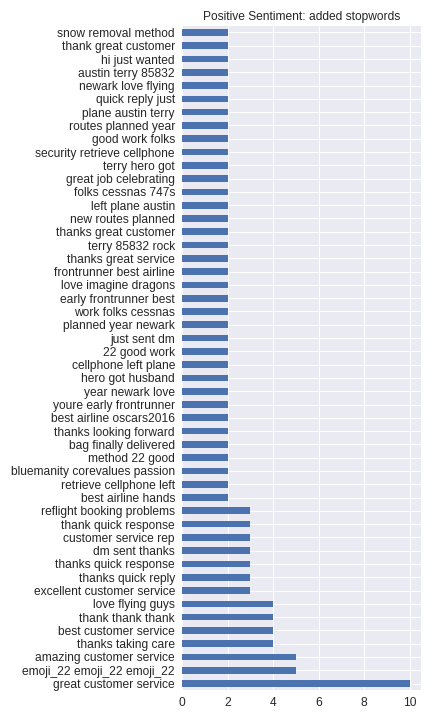

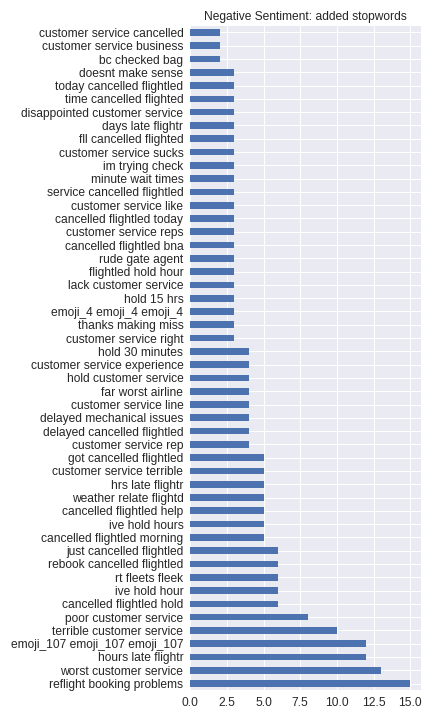

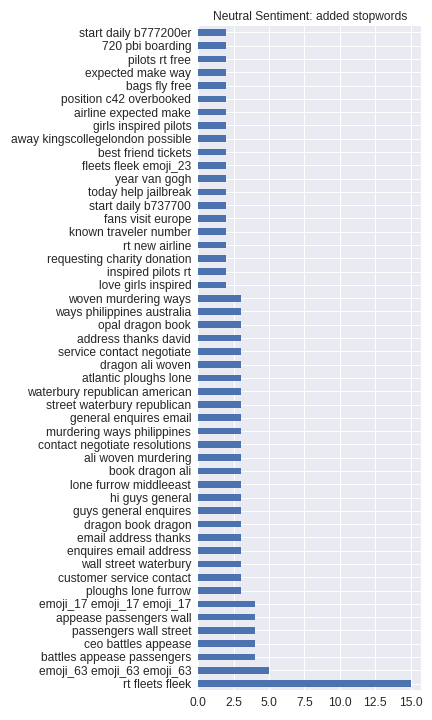

In [77]:
im = Image(filename = img_EDA_NB1 + "Trigrams_pos_sent_stopwused.png")
display(im)

im = Image(filename = img_EDA_NB1 + "Trigrams_neg_sent_stopwused.png")
display(im)

im = Image(filename = img_EDA_NB1 + "Trigrams_neut_sent_stopwused.png")
display(im)

### Tri-grams observed for the 3 classes using  cleaned text+stopwords

In [ ]:
# Positive Trigrams:
#        ['great customer service', 'emoji_22 emoji_22 emoji_22',
#        'amazing customer service', 'thanks taking care',
#        'best customer service', 'thank thank thank', 'love flying guys',
#        'excellent customer service', 'thanks quick reply',
#        'thanks quick response', 'dm sent thanks', 'customer service rep',
#        'thank quick response', 'reflight booking problems',
#        'best airline hands', 'retrieve cellphone left',
#        'bluemanity corevalues passion', 'method 22 good',
#        'bag finally delivered', 'thanks looking forward',
#        'best airline oscars2016', 'youre early frontrunner',
#        'year newark love', 'hero got husband', 'cellphone left plane',
#        '22 good work', 'just sent dm', 'planned year newark',
#        'work folks cessnas', 'early frontrunner best', 'love imagine dragons',
#        'frontrunner best airline', 'thanks great service', 'terry 85832 rock',
#        'thanks great customer', 'new routes planned', 'left plane austin',
#        'folks cessnas 747s', 'great job celebrating', 'terry hero got',
#        'security retrieve cellphone', 'good work folks', 'routes planned year',
#        'plane austin terry', 'quick reply just', 'newark love flying',
#        'austin terry 85832', 'hi just wanted', 'thank great customer',
#        'snow removal method']

# Negative Bigrams:
#        ['reflight booking problems', 'worst customer service',
#        'hours late flightr', 'emoji_107 emoji_107 emoji_107',
#        'terrible customer service', 'poor customer service',
#        'cancelled flightled hold', 'ive hold hour', 'rt fleets fleek',
#        'rebook cancelled flightled', 'just cancelled flightled',
#        'cancelled flightled morning', 'ive hold hours',
#        'cancelled flightled help', 'weather relate flightd',
#        'hrs late flightr', 'customer service terrible',
#        'got cancelled flightled', 'customer service rep',
#        'delayed cancelled flightled', 'delayed mechanical issues',
#        'customer service line', 'far worst airline', 'hold customer service',
#        'customer service experience', 'hold 30 minutes',
#        'customer service right', 'thanks making miss',
#        'emoji_4 emoji_4 emoji_4', 'hold 15 hrs', 'lack customer service',
#        'flightled hold hour', 'rude gate agent', 'cancelled flightled bna',
#        'customer service reps', 'cancelled flightled today',
#        'customer service like', 'service cancelled flightled',
#        'minute wait times', 'im trying check', 'customer service sucks',
#        'fll cancelled flighted', 'days late flightr',
#        'disappointed customer service', 'time cancelled flighted',
#        'today cancelled flightled', 'doesnt make sense', 'bc checked bag',
#        'customer service business', 'customer service cancelled']

# Neutral Bigrams:
#        ['rt fleets fleek', 'emoji_63 emoji_63 emoji_63',
#        'battles appease passengers', 'ceo battles appease',
#        'passengers wall street', 'appease passengers wall',
#        'emoji_17 emoji_17 emoji_17', 'ploughs lone furrow',
#        'customer service contact', 'wall street waterbury',
#        'enquires email address', 'email address thanks', 'dragon book dragon',
#        'guys general enquires', 'hi guys general', 'lone furrow middleeast',
#        'book dragon ali', 'ali woven murdering',
#        'contact negotiate resolutions', 'murdering ways philippines',
#        'general enquires email', 'street waterbury republican',
#        'waterbury republican american', 'atlantic ploughs lone',
#        'dragon ali woven', 'service contact negotiate', 'address thanks david',
#        'opal dragon book', 'ways philippines australia',
#        'woven murdering ways', 'love girls inspired', 'inspired pilots rt',
#        'requesting charity donation', 'rt new airline',
#        'known traveler number', 'fans visit europe', 'start daily b737700',
#        'today help jailbreak', 'year van gogh', 'fleets fleek emoji_23',
#        'best friend tickets', 'away kingscollegelondon possible',
#        'girls inspired pilots', 'airline expected make',
#        'position c42 overbooked', 'bags fly free', 'expected make way',
#        'pilots rt free', '720 pbi boarding', 'start daily b777200er']

### Observations: 
`Grouping words together` can really `start to show us the story or topics` being communicated by the data.<br>
At the same time, `some tri-grams start to loose meaning`, like:
1. dragon book dragon
2. love girls inspired
3. hero got husband 

## [Next Notebook: Modeling](3_TechnicalP_Modeling.ipynb) 